# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=f69257e21b52a74e39ceee9725633c918fc6d993442b230fd1e867ec21150d59
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=f2824bc394859d88e5b310633c766f165fcdad2115e1426a42309b3777746c1c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

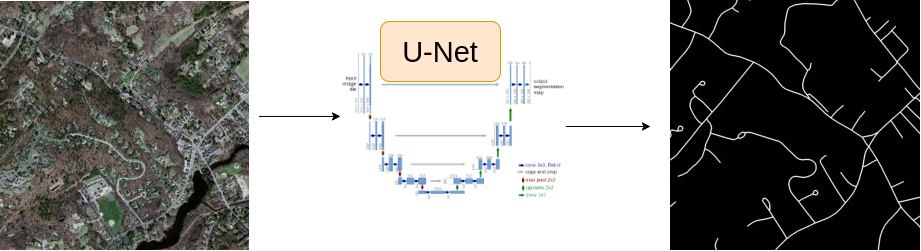

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [7]:
idx = 17
row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

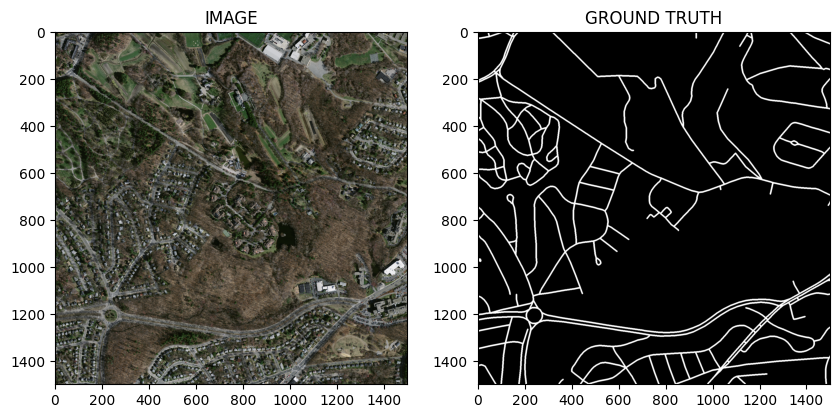

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

In [10]:
print(len(valid_df))
print(len(train_df))

40
159


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (h, w)
    mask = np.expand_dims(mask, axis=-1)  # (h, w, c)

    if self.augmentations:
        data = self.augmentations(image=image, mask=mask)
        image = data['image']
        mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # (c, h, w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)  # (c, h, w)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f'Size of trainset: {len(trainset)}')
print(f'Size of validset: {len(validset)}')

Size of trainset: 159
Size of validset: 40


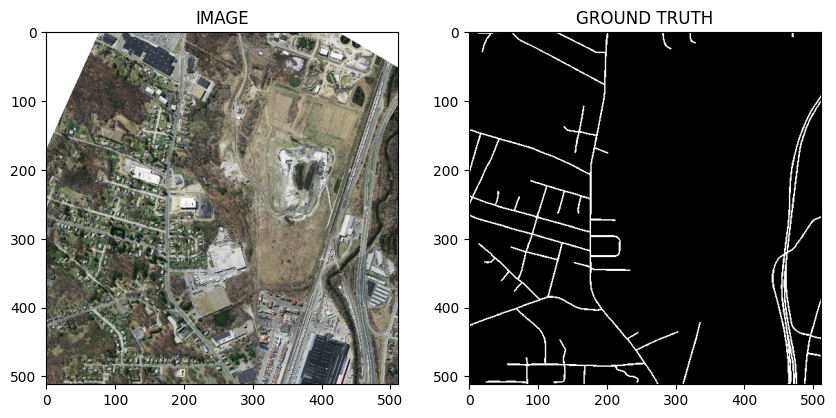

In [17]:
idx = 5
image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [20]:
print(f'Total no. of batches in trainloader: {len(trainloader)} and in validloader: {len(validloader)}')

Total no. of batches in trainloader: 20 and in validloader: 5


In [21]:
for images, masks in trainloader:
  print(f'One batch image shape: {images.shape} and mask shape: {masks.shape}')
  break

One batch image shape: torch.Size([8, 3, 512, 512]) and mask shape: torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [23]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [24]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 37.9MB/s]


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7 : Create Train and Validation Function

In [25]:
def train_fn(dataloader, model, optimizer):
  model.train() # turn on dropout, batchnorm etc...
  total_loss = 0.0

  for images, masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)

In [26]:
def eval_fn(dataloader, model):
  model.eval() # turn off dropout, batchnorm etc...
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss / len(dataloader)

# Task 8 : Train Model

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [28]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_loss = valid_loss

  print(f'Epoch : {i+1} Train Loss: {train_loss}, Valid Loss: {valid_loss}')

100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


SAVED MODEL
Epoch : 1 Train Loss: 1.2603730082511901, Valid Loss: 1.1518649578094482


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


SAVED MODEL
Epoch : 2 Train Loss: 0.8315716087818146, Valid Loss: 0.8425767540931701


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch : 3 Train Loss: 0.7299677461385727, Valid Loss: 1.0247456073760985


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


SAVED MODEL
Epoch : 4 Train Loss: 0.692460685968399, Valid Loss: 0.7186045169830322


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch : 5 Train Loss: 0.6664293229579925, Valid Loss: 0.7480562210083008


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


SAVED MODEL
Epoch : 6 Train Loss: 0.6540595918893815, Valid Loss: 0.6771730542182922


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


SAVED MODEL
Epoch : 7 Train Loss: 0.6395488917827606, Valid Loss: 0.6658743858337403


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch : 8 Train Loss: 0.6321607053279876, Valid Loss: 0.7255025267601013


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch : 9 Train Loss: 0.6343806236982346, Valid Loss: 0.7000364661216736


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch : 10 Train Loss: 0.6313428521156311, Valid Loss: 0.698941707611084


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch : 11 Train Loss: 0.6345958858728409, Valid Loss: 0.6923960089683533


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


SAVED MODEL
Epoch : 12 Train Loss: 0.6171192198991775, Valid Loss: 0.6564433574676514


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch : 13 Train Loss: 0.5994628936052322, Valid Loss: 0.6569787979125976


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch : 14 Train Loss: 0.6034947812557221, Valid Loss: 0.6807732462882996


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch : 15 Train Loss: 0.6064578801393509, Valid Loss: 0.6575327754020691


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED MODEL
Epoch : 16 Train Loss: 0.5962778344750405, Valid Loss: 0.650817334651947


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


SAVED MODEL
Epoch : 17 Train Loss: 0.5893536135554314, Valid Loss: 0.6219703316688537


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch : 18 Train Loss: 0.5864942207932472, Valid Loss: 0.6668243646621704


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch : 19 Train Loss: 0.5898117691278457, Valid Loss: 0.6289428472518921


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch : 20 Train Loss: 0.587537744641304, Valid Loss: 0.6303063154220581


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch : 21 Train Loss: 0.577789568901062, Valid Loss: 0.6801318407058716


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch : 22 Train Loss: 0.5871293544769287, Valid Loss: 0.6669469118118286


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED MODEL
Epoch : 23 Train Loss: 0.5762363687157631, Valid Loss: 0.6158580541610718


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch : 24 Train Loss: 0.5749181523919106, Valid Loss: 0.6366091251373291


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]

Epoch : 25 Train Loss: 0.5661695227026939, Valid Loss: 0.6501298427581788


# Task 9 : Inference

In [35]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) -> (b, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

<ipython-input-35-20e60f4aae86>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


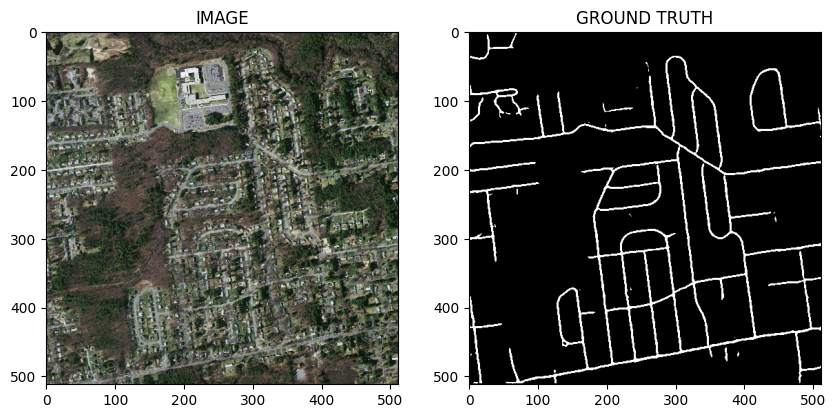

In [36]:
helper.show_image(image, pred_mask.detach().cpu().squeeze(0))